In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import SARIMAX
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import itertools

# Visualization

## Data Preprocessing before importing to Tableau

In [2]:
marvel_comics = pd.read_csv('marvel_comics.csv')
marvel_comics.shape

(34992, 12)

In [3]:
df_cleaned = marvel_comics.dropna(subset=['issue_description']) #drop NAs in issue_description column that we will tokenize.
df_cleaned.shape

(30395, 12)

In [4]:
df_cleaned.isna().sum() #checking null values on each column

comic_name               0
active_years             0
issue_title              0
publish_date             0
issue_description        0
penciler              6176
writer                4268
cover_artist         18412
Imprint              19289
Format                1084
Rating               18018
Price                 1084
dtype: int64

### Tokenization

In [5]:
#Tokenizing 'issue_description' column
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import string

def tokenize_and_process(text):
    tokens = word_tokenize(text)
    # Remove punctuation and convert to lower case
    tokens = [word.lower() for word in tokens if word.isalpha()]
    return tokens

# Tokenize 'issue_description' column
df_cleaned['token_issue_desc'] = df_cleaned['issue_description'].apply(tokenize_and_process)


[nltk_data] Downloading package punkt to /Users/jiunlee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

/var/folders/n_/44qv0dbs5vs6nm55y9wjtfr80000gn/T/ipykernel_87994/1642140268.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['token_issue_desc'] = df_cleaned['issue_description'].apply(tokenize_and_process)


### Removing Stopwords

In [6]:
# Removing stopwords among tokens
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df_cleaned['token_issue_desc'] = df_cleaned['token_issue_desc'].apply(lambda tokens: [token for token in tokens if token not in stop_words])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

/var/folders/n_/44qv0dbs5vs6nm55y9wjtfr80000gn/T/ipykernel_87994/689252755.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['token_issue_desc'] = df_cleaned['token_issue_desc'].apply(lambda tokens: [token for token in tokens if token not in stop_words])


### Lemmatization

In [7]:
from nltk.stem import WordNetLemmatizer
import string

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess_tokens(tokens):
    # Remove punctuation and numbers, and then lemmatize
    return [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]

df_cleaned['processed_issue_desc'] = df_cleaned['token_issue_desc'].apply(preprocess_tokens)


[nltk_data] Downloading package wordnet to /Users/jiunlee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

/var/folders/n_/44qv0dbs5vs6nm55y9wjtfr80000gn/T/ipykernel_87994/2577712323.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['processed_issue_desc'] = df_cleaned['token_issue_desc'].apply(preprocess_tokens)


In [8]:
df_cleaned[['issue_description','token_issue_desc','processed_issue_desc']].head()

,issue_description,token_issue_desc,processed_issue_desc
0,The Infinite Comic that will have everyone tal...,"[infinite, comic, everyone, talking, full, fun...","[infinite, comic, everyone, talking, full, fun..."
1,"It’s August, and Nick Fury is just in time to ...","[august, nick, fury, time, attend, japan, bon,...","[august, nick, fury, time, attend, japan, bon,..."
2,Join us in a brand new Marvel comics adventure...,"[join, us, brand, new, marvel, comics, adventu...","[join, u, brand, new, marvel, comic, adventure..."
3,Celebrating the Fourth of July is complicated ...,"[celebrating, fourth, july, complicated, enoug...","[celebrating, fourth, july, complicated, enoug..."
4,Sam Alexander’s finding it hard to cope with t...,"[sam, alexander, finding, hard, cope, fact, da...","[sam, alexander, finding, hard, cope, fact, da..."


### Create column for sentiment analysis

In [9]:
import textblob 
from textblob import TextBlob
# Use original column for analyzing sentiment
df_cleaned['sentiment_desc'] = df_cleaned['issue_description'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Classify sentiment into categories
df_cleaned['sentiment_category'] = pd.cut(df_cleaned['sentiment_desc'], bins=3, labels=["Negative", "Neutral", "Positive"])


/var/folders/n_/44qv0dbs5vs6nm55y9wjtfr80000gn/T/ipykernel_87994/1524328198.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sentiment_desc'] = df_cleaned['issue_description'].apply(lambda x: TextBlob(x).sentiment.polarity)
/var/folders/n_/44qv0dbs5vs6nm55y9wjtfr80000gn/T/ipykernel_87994/1524328198.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sentiment_category'] = pd.cut(df_cleaned['sentiment_desc'], bins=3, labels=["Negative", "Neutral", "Positive"])


In [10]:
# save the cleaned dataset
filename = "comics_cleaned.csv"

# write the DataFrame to a CSV file
df_cleaned.to_csv(filename, index=False)

print(f"File '{filename}' saved successfully!")


File 'comics_cleaned.csv' saved successfully!


### Explode the Tokenized Column

In [11]:
exploded_comic = df_cleaned.explode('processed_issue_desc')
#Use the explode() function to create individual rows for each token, while keeping the other column data intact.
exploded_comic.head()

,comic_name,active_years,issue_title,publish_date,issue_description,penciler,writer,cover_artist,Imprint,Format,Rating,Price,token_issue_desc,processed_issue_desc,sentiment_desc,sentiment_category
0,A Year of Marvels: April Infinite Comic (2016),(2016),A Year of Marvels: April Infinite Comic (2016) #1,"April 01, 2016",The Infinite Comic that will have everyone tal...,Yves Bigerel,Yves Bigerel,Jamal Campbell,Marvel Universe,Infinite Comic,Rated T+,Free,"[infinite, comic, everyone, talking, full, fun...",infinite,0.345833,Positive
0,A Year of Marvels: April Infinite Comic (2016),(2016),A Year of Marvels: April Infinite Comic (2016) #1,"April 01, 2016",The Infinite Comic that will have everyone tal...,Yves Bigerel,Yves Bigerel,Jamal Campbell,Marvel Universe,Infinite Comic,Rated T+,Free,"[infinite, comic, everyone, talking, full, fun...",comic,0.345833,Positive
0,A Year of Marvels: April Infinite Comic (2016),(2016),A Year of Marvels: April Infinite Comic (2016) #1,"April 01, 2016",The Infinite Comic that will have everyone tal...,Yves Bigerel,Yves Bigerel,Jamal Campbell,Marvel Universe,Infinite Comic,Rated T+,Free,"[infinite, comic, everyone, talking, full, fun...",everyone,0.345833,Positive
0,A Year of Marvels: April Infinite Comic (2016),(2016),A Year of Marvels: April Infinite Comic (2016) #1,"April 01, 2016",The Infinite Comic that will have everyone tal...,Yves Bigerel,Yves Bigerel,Jamal Campbell,Marvel Universe,Infinite Comic,Rated T+,Free,"[infinite, comic, everyone, talking, full, fun...",talking,0.345833,Positive
0,A Year of Marvels: April Infinite Comic (2016),(2016),A Year of Marvels: April Infinite Comic (2016) #1,"April 01, 2016",The Infinite Comic that will have everyone tal...,Yves Bigerel,Yves Bigerel,Jamal Campbell,Marvel Universe,Infinite Comic,Rated T+,Free,"[infinite, comic, everyone, talking, full, fun...",full,0.345833,Positive


In [12]:
#Save the exploded dataset
filename = "exploded_tokens.csv"

# write the DataFrame to a CSV file
exploded_comic.to_csv(filename, index=False)

print(f"File '{filename}' saved successfully!")


File 'exploded_tokens.csv' saved successfully!


## Tableau

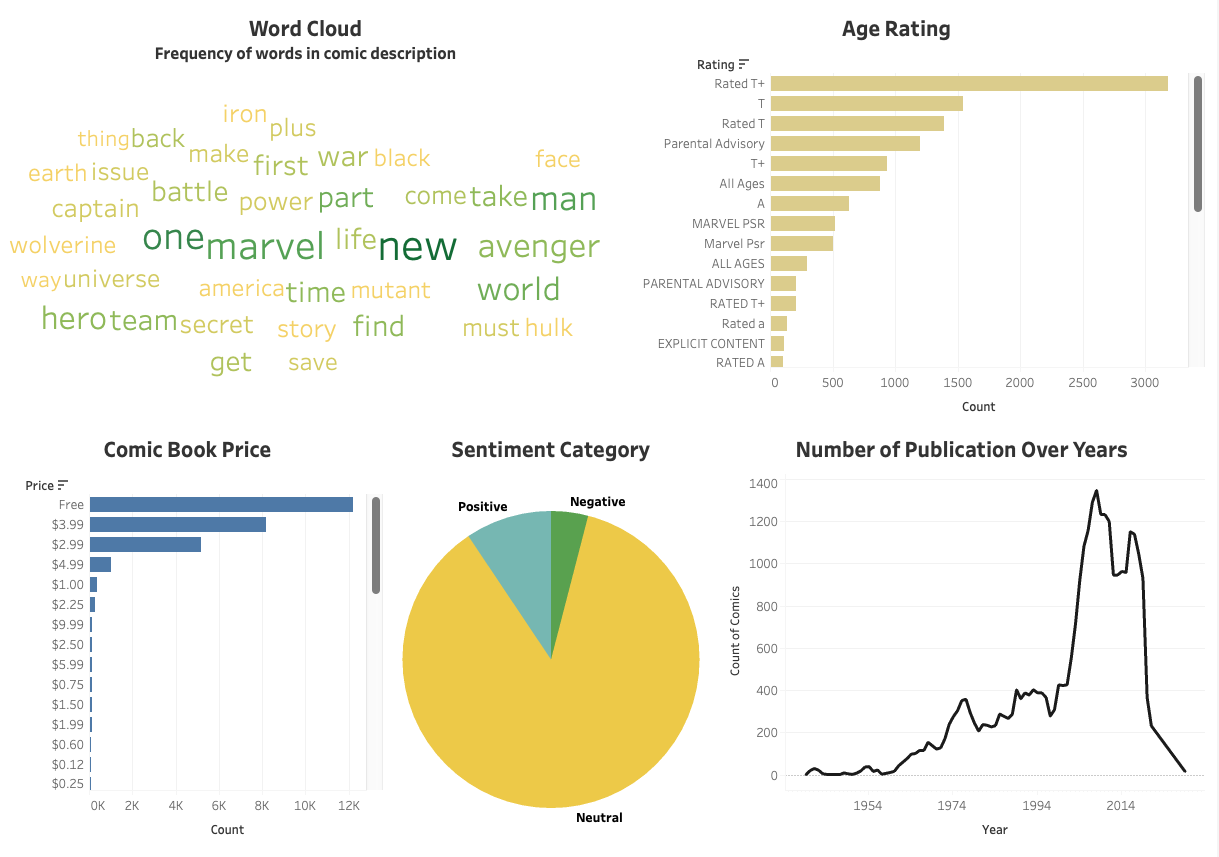

In [13]:
PATH = 'Tableau_Screenshot.png'
from IPython.display import Image
Image(filename = PATH, width=75000, height=500)

https://public.tableau.com/app/profile/jiun.lee/viz/Marvel_Comics/Dashboard1?publish=yes

These visualizations offer insights into various aspects of Marvel comic books. The initial one is a word cloud, highlighting the most common terms in comic book descriptions, such as "new," "marvel," "one," "man," and "hero." These terms frequently appear, reflecting the focus on Marvel heroes in the descriptions.

We also conducted a sentiment analysis of the descriptions, revealing that the majority exhibit a "Neutral" tone, followed by "Positive" and "Negative." This predominance of neutrality is plausible, as these descriptions aim to outline the comic's content rather than express subjective opinions, like comic book reviews with strong negative and positive tones.

The 'Age Rating' chart presents the most common age ratings in Marvel comics, with "Rated T+," "T," and "Rated T" being the top three. This trend toward a teenage audience potentially broadens the comics' appeal, making them accessible to a wide age range.

The "Number of Publications Over Years" graph illustrates a declining trend in publication numbers post-2014. This trend is concerning as it indicates a reduction in Marvel's essential content. Such content sustains the original Marvel character fanbase and is crucial for developing new Marvel movies. Marvel might consider boosting its publication frequency.

Regarding pricing, the 'Comic Book Price' graph indicates that the most frequent price point is 'Free.' While free comics can attract a larger audience and boost popularity, they might not contribute significantly to revenue, highlighting a need for strategic pricing.

These visualizations shed light on different facets of Marvel comics. However, additional data on revenue, number of buyers, buyer demographics, and other factors influencing profit would be valuable for a more comprehensive analysis. Such information could provide deeper insights into Marvel Comics' profitability and suggest ways to enhance its business strategy.

# Summary Statistics

In [14]:
# read in marvel_movies.csv
marvel_movies = pd.read_csv('marvel_movies.csv')

In [15]:
marvel_movies

,film,category,worldwide gross ($m),% budget recovered,critics % score,audience % score,audience vs critics % deviance,budget,domestic gross ($m),international gross ($m),opening weekend ($m),second weekend ($m),1st vs 2nd weekend drop off,% gross from opening weekend,% gross from domestic,% gross from international,% budget opening weekend,year,source
0,Ant-Man,Ant-Man,518,398%,83%,85%,-2%,130.0,180,338,57.0,24.0,-58%,31.8,34.7%,65.3%,43.8%,2015,https://www.the-numbers.com/movie/Ant-Man#tab=...
1,Ant-Man & The Wasp,Ant-Man,623,479%,87%,80%,7%,130.0,216,406,75.8,29.0,-62%,35.0,34.7%,65.2%,58.3%,2018,https://www.the-numbers.com/movie/Ant-Man-and-...
2,Avengers: Age of Ultron,Avengers,1395,382%,76%,82%,-6%,365.0,459,936,191.0,77.0,-60%,41.7,32.9%,67.1%,52.3%,2015,https://www.the-numbers.com/movie/Avengers-Age...
3,Avengers: End Game,Avengers,2797,699%,94%,90%,4%,400.0,858,1939,357.0,147.0,-59%,41.6,30.7%,69.3%,89.3%,2019,https://www.the-numbers.com/movie/Avengers-End...
4,Avengers: Infinity War,Avengers,2048,683%,85%,91%,-6%,300.0,678,1369,257.0,114.0,-56%,38.0,33.1%,66.8%,85.7%,2018,https://www.the-numbers.com/movie/Avengers-Inf...
5,Black Panther,Black Panther,1336,668%,96%,79%,17%,200.0,700,636,202.0,111.0,-45%,28.9,52.4%,47.6%,101.0%,2018,https://www.the-numbers.com/movie/Black-Panthe...
6,Black Panther 2,Black Panther,855,342%,84%,94%,-10%,250.0,453,401,181.0,66.0,-64%,48.6,53.0%,46.9%,72.4%,2022,https://www.the-numbers.com/movie/Black-Panthe...
7,Black Widow,Unique,379,190%,79%,80%,-1%,200.0,183,196,80.3,25.8,-68%,43.8,48.3%,51.7%,40.2%,2021,https://www.the-numbers.com/movie/Black-Widow-...
8,Captain America,Captain America,370,264%,79%,75%,4%,140.0,176,193,65.0,25.0,-62%,36.8,47.6%,52.2%,46.4%,2011,https://www.the-numbers.com/movie/Captain-Amer...
9,Captain America: Civil War,Captain America,1151,460%,90%,89%,1%,250.0,408,743,179.0,72.6,-59%,43.9,35.4%,64.6%,71.6%,2016,https://www.the-numbers.com/movie/Captain-Amer...


In [16]:
# all the % columns are listed as objects. need to convert to int 
columns_to_convert = [
    '% budget recovered',
    'critics % score',
    'audience % score',
    'audience vs critics % deviance',
    '1st vs 2nd weekend drop off',
    '% gross from domestic',
    '% gross from international',
    '% budget opening weekend'
]

for column in columns_to_convert:
    marvel_movies[column] = marvel_movies[column].apply(lambda x: int(float(str(x).replace('%', '').replace(',', ''))) if pd.notna(x) else None)

### Gross Revenue Statistics

In [17]:
summary = marvel_movies.describe()


In [18]:
summary[['worldwide gross ($m)','domestic gross ($m)', 'international gross ($m)']]

,worldwide gross ($m),domestic gross ($m),international gross ($m)
count,30.000000,30.000000,30.000000
mean,940.866667,370.900000,569.433333
std,563.119068,193.394603,387.182634
min,265.000000,134.000000,130.000000
25%,594.000000,218.000000,315.500000
50%,810.000000,333.500000,448.500000
75%,1146.250000,422.250000,731.250000
max,2797.000000,858.000000,1939.000000


Text(0.5, 1.0, 'Boxplot of Gross Revenue')

Text(0, 0.5, 'Revenue ($m)')

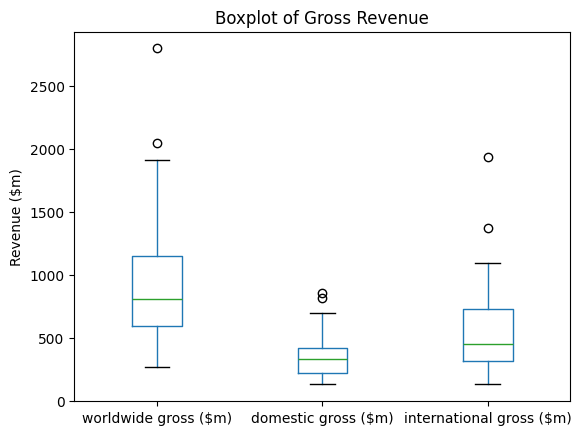

In [19]:

boxplot = marvel_movies.boxplot(column=['worldwide gross ($m)', 'domestic gross ($m)', 'international gross ($m)'])
plt.title('Boxplot of Gross Revenue')
plt.ylabel('Revenue ($m)')
plt.grid(False)  # This disables the grid lines
plt.show()


We analyzed the global revenue distribution by creating a box plot of domestic and international gross earnings. International revenue constitutes a significant portion of worldwide earnings. This suggests a strong global fanbase for Marvel, giving insight to Marvel that they may need to target international audiences more than domestic fans.

### International gross revenue VS Domestic gross revenue

In [20]:
# Add a new column 'Category' which is 1 if 'International' > 'Domestic Gross', otherwise 0
marvel_movies['International_bigger'] = marvel_movies.apply(lambda row: 1 if row['% gross from international'] > row['% gross from domestic'] else 0, axis=1)


In [21]:
pivot = marvel_movies.pivot_table(values='worldwide gross ($m)',
                                  index = 'International_bigger',
                                  aggfunc=[np.mean,min,max])
pivot

,mean,min,max
,worldwide gross ($m),worldwide gross ($m),worldwide gross ($m)
International_bigger,,,
0,682.333333,265,1336
1,1005.500000,370,2797


After examining the box plot of gross revenue, our curiosity led us to explore the impact of international gross revenue on worldwide gross revenue. We introduced a binary variable, 'International_bigger,' which denotes whether global gross revenue exceeds domestic revenue, enabling us to observe the worldwide revenue's summary statistics categorized by 'International_bigger.' It shows that worldwide gross revenue generally increases when international revenue surpasses domestic revenue (International_bigger=1). This suggests that Marvel Studio's financial success may rely more on its global audience. This provides strong evidence that Marvel's primary customer is international audiences.

### Total number of films and total gross revenue grouped by category

In [22]:
summary_df = marvel_movies.groupby('category').agg(
    count=('film', 'count'),
    total_gross=('worldwide gross ($m)', 'sum')
).reset_index()
summary_df

,category,count,total_gross
0,Ant-Man,2,1141
1,Avengers,4,7755
2,Black Panther,2,2191
3,Captain America,3,2235
4,Dr Strange,2,1628
5,Guardians,2,1639
6,Iron Man,3,2421
7,Spider-Man,3,3921
8,Thor,4,2688
9,Unique,5,2607


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Marvel Movie Categories: Count vs Total Gross')

([<matplotlib.axis.XTick at 0x156834fd0>,
 [Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4'), Text(5, 0, '5')])

Text(0.5, 0, 'Count of Films')

Text(0, 0.5, 'Revenue ($m)')

Text(2, 1141, 'Ant-Man\n')

Text(4, 7755, 'Avengers\n')

Text(2, 2191, 'Black Panther\n')

Text(3, 2235, 'Captain America\n')

Text(2, 1628, 'Dr Strange\n')

Text(2, 1639, 'Guardians\n')

Text(3, 2421, 'Iron Man\n')

Text(3, 3921, 'Spider-Man\n')

Text(4, 2688, 'Thor\n')

Text(5, 2607, 'Unique\n')

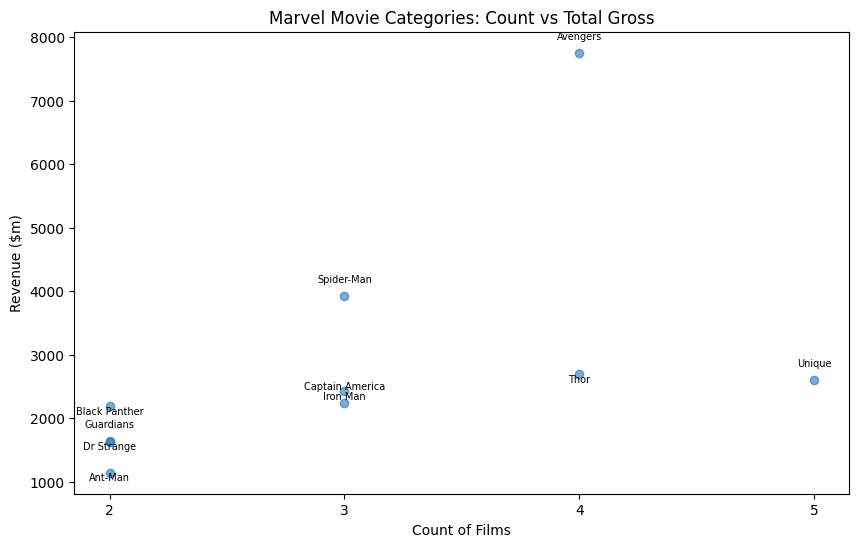

In [23]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(summary_df['count'], summary_df['total_gross'], alpha=0.6)
plt.title('Marvel Movie Categories: Count vs Total Gross')
plt.xticks([2, 3, 4, 5])
plt.xlabel('Count of Films')
plt.ylabel('Revenue ($m)')

for i, txt in enumerate(summary_df['category']):
    va = 'top' if i % 2 == 0 else 'bottom'
    plt.annotate(txt + '\n', (summary_df['count'][i], summary_df['total_gross'][i]),
                 ha='center', va=va, fontsize=7, multialignment='center')

plt.show()

Using groupby ('category'), we calculated the total worldwide gross of each category and counted the number of films in each category. The "Unique" category contains Marvel movies that are not series movies, such as "Sang Chi," "Incredible Hulk," "Eternals," and so on. Even though the "Unique" category contains the biggest number of films, its total gross revenue is somehow lower than the "Spider-Man" and "Avengers" categories with fewer films. This might be because movies in the "Unique" category were not well-received. Also, even though the “Black Panther” category has only 2 films its total gross isn’t significantly lower than the “Unique” category having 5 films. 



### Average Audience Score grouped by category

In [24]:
summary_df = marvel_movies.groupby('category').agg(
    count=('film', 'count'),
    Average_gross=('worldwide gross ($m)', 'mean'),
    mean_audience_score = ('audience % score','mean')
    ).reset_index()
summary_df.sort_values(by='mean_audience_score',ascending=False)

,category,count,Average_gross,mean_audience_score
7,Spider-Man,3,1307.00,92.000000
5,Guardians,2,819.50,89.500000
1,Avengers,4,1938.75,88.500000
2,Black Panther,2,1095.50,86.500000
3,Captain America,3,745.00,85.333333
0,Ant-Man,2,570.50,82.500000
4,Dr Strange,2,814.00,81.500000
6,Iron Man,3,807.00,80.000000
8,Thor,4,672.00,75.250000
9,Unique,5,521.40,72.000000


To see if our assumption was correct, we got the mean value of audience scores grouped by each category and sorted by descending order to see the most well-received Marvel movie series. As we assumed earlier, the "Unique" category shows the lowest mean of the audience score out of all categories and also got the minimum average gross revenue. The top 5 movies with higher mean audience scores show a higher average gross revenue than other movies. This implies that audience score might be related to films' revenue. Therefore, Marvel might need to produce more well-received movies that can earn higher audience scores to generate higher revenue.

### Average worldwide gross revenue of films grouped by year.

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='year'>

([<matplotlib.axis.XTick at 0x1568ce190>,
 [Text(2008, 0, '2008'),
  Text(2009, 0, '2009'),
  Text(2010, 0, '2010'),
  Text(2011, 0, '2011'),
  Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022')])

<Figure size 1000x600 with 0 Axes>

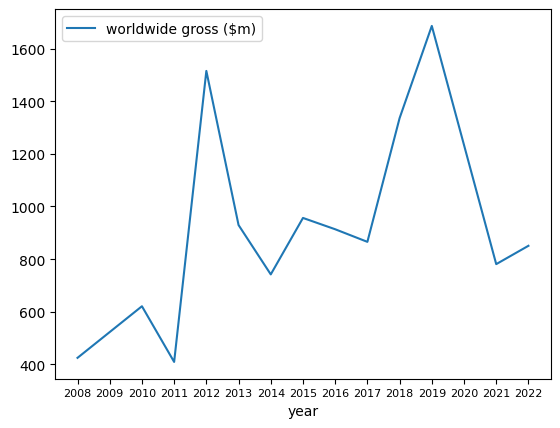

In [25]:
pivot = marvel_movies.pivot_table(values='worldwide gross ($m)', 
                                  index='year', 
                                  aggfunc='mean')
plt.figure(figsize=(10, 6))
pivot.plot()
plt.xticks(range(2008, 2023),fontsize = 8)
plt.show()

The graph displays the average worldwide gross revenue for Marvel films each year. Since 2011, a general upward trend in revenue has peaked dramatically in 2019. 
This peak could be correlated with the release of popular films in the Marvel Cinematic Universe that were highly anticipated and well-received. 
However, following 2019, there was a steep drop in 2020, likely due to external factors such as the global COVID-19 pandemic, which impacted box office earnings. However, from 2021, a partial recovery suggests a return to form for Marvel movies. along with recovery, If Marvel made more well-received movies it could have a second peak like in 2019.


# Segmentation and Targeting

## Data Cleaning

In [85]:
# read in regional_families.csv dataset
regional_families = pd.read_csv('regional_families.csv')

In [86]:
regional_families.head()

,householdID,dietary_spec,dist_park,email_sub,est_inc,hhold_size,leisure_perc,oldest,passholder,previous_attend,social_media_scale,youngest
0,1,NaN,0.9,No,62641.584126,2,0.08,92,1,1,0.70,13
1,2,NaN,23.8,Yes,70127.969071,3,0.21,41,1,4,0.29,24
2,3,NaN,27.3,No,112130.429602,1,0.11,67,1,1,0.08,67
3,4,NaN,20.7,No,76096.440915,2,0.04,31,1,1,0.99,1
4,5,Gluten-Free,55.1,Yes,79925.089485,6,0.27,52,0,0,0.22,25


In [87]:
regional_families.drop('householdID', axis=1, inplace=True)

In [88]:
regional_families.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dietary_spec        1768 non-null   object 
 1   dist_park           8500 non-null   float64
 2   email_sub           8500 non-null   object 
 3   est_inc             8500 non-null   float64
 4   hhold_size          8500 non-null   int64  
 5   leisure_perc        8500 non-null   float64
 6   oldest              8500 non-null   int64  
 7   passholder          8500 non-null   int64  
 8   previous_attend     8500 non-null   int64  
 9   social_media_scale  8500 non-null   float64
 10  youngest            8500 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 730.6+ KB


In [89]:
# change email_sub to binary variable
regional_families['email_sub'] = regional_families['email_sub'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

## Variable Selection

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix')

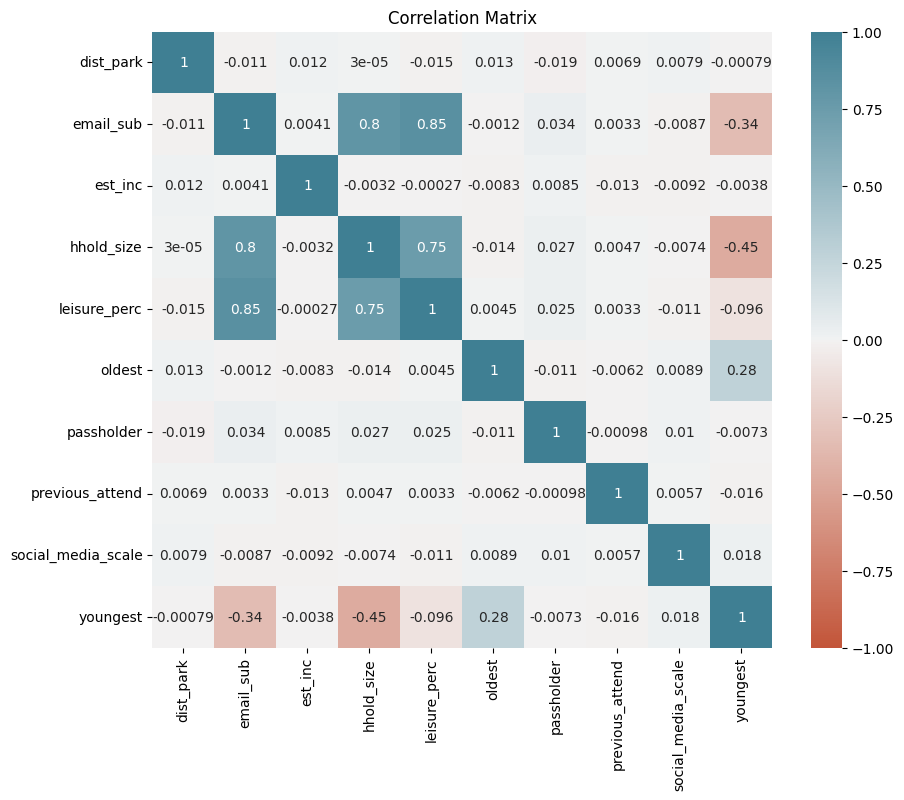

In [90]:
# check for highly correlated variables to avoid redundancy
correlation_matrix = regional_families.iloc[:, 1:].corr()

# Custom colormap
cmap = sns.diverging_palette(20, 220, as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, center=0, vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

- to avoid redundancy and reduce dimensionality, take a subset of our dataset

In [91]:
# we choose to select the following variables in our k-means model
columns = ['dist_park', 'email_sub', 'leisure_perc', 'previous_attend', 'youngest']
regional_fam_num = regional_families[columns]

## K-means Clustering

### Elbow Chart

KMeans(n_clusters=1, random_state=654)

KMeans(n_clusters=2, random_state=654)

KMeans(n_clusters=3, random_state=654)

KMeans(n_clusters=4, random_state=654)

KMeans(n_clusters=5, random_state=654)

KMeans(n_clusters=6, random_state=654)

KMeans(n_clusters=7, random_state=654)

KMeans(random_state=654)

KMeans(n_clusters=9, random_state=654)

KMeans(n_clusters=10, random_state=654)

KMeans(n_clusters=11, random_state=654)

KMeans(n_clusters=12, random_state=654)

KMeans(n_clusters=13, random_state=654)

KMeans(n_clusters=14, random_state=654)

<Axes: >

Text(0.5, 1.0, 'The Elbow Method')

Text(0.5, 0, 'k')

Text(0, 0.5, 'SSE')

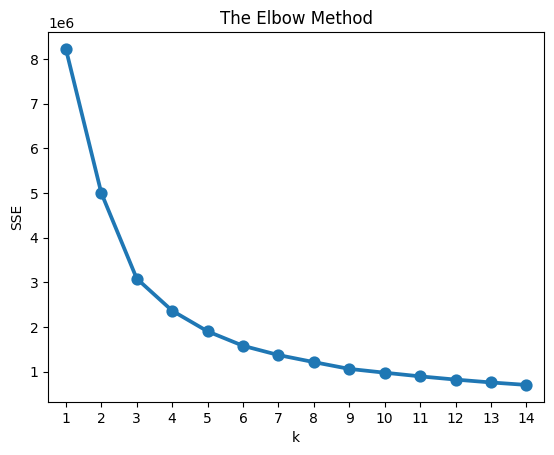

In [92]:
# Try different values of k (number of clusters)
sse = {}
for k in range(1, 15):
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=654) 
    
    # Fit KMeans on the normalized dataset 
    kmeans.fit(regional_fam_num) 
    sse[k] = kmeans.inertia_

sns.pointplot(x=list(sse.keys()), y=list(sse.values()));
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

Based on the elbow plot, it seems that a k value of 3-5 clusters seems appropriate. After running the model with 3, 4, and 5  as the k values, it seems that 4 clusters provides the most distinct mean values for each cluster, as each displays an 'out of line' value for at least one feature. For example, cluster 0 has a particularly high mean value for `youngest`. Cluster 3 displays a very high mean value for `dist park`. Therefore we select 4 in order to segment the clientele base to better our targeting mechanisms.

In [94]:
scaler = StandardScaler()
regional_fam_num_standardized = scaler.fit_transform(regional_fam_num)

# kmeans model with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=654)
kmeans.fit(regional_fam_num_standardized)

KMeans(n_clusters=4, random_state=654)

### Summary Statistics for Clusters

In [95]:
cluster_labels = kmeans.labels_
regional_fam_k4 = regional_fam_num.assign(Cluster = cluster_labels)
regional_fam_k4.groupby(['Cluster']).agg({
    'dist_park' : 'mean',
    'email_sub': 'mean',
    'leisure_perc' : 'mean',
    'previous_attend':'mean',
    'youngest':['mean', 'count'],
}).round(2)

dist_park email_sub leisure_perc previous_attend youngest      
             mean      mean         mean            mean     mean count
Cluster                                                                
0           15.99      1.00         0.23            2.00    22.91  3233
1           15.61      0.00         0.08            2.03    21.38  2716
2           16.14      0.00         0.13            1.95    65.05  1898
3           72.43      0.36         0.14            2.06    31.17   653

**Cluster 0**: Youngsters. This cluster has the lowest average age for each household; there are probably young children/teenagers within these households. To  target this cluster, it would be best to utilize social media posts and advertisements. Platforms like Instagram, TikTok, and Instagram allow advertisers to create targeted ads towards specific age groups. Since young people often use social platforms, it would be best to focus here.

**Cluster 1**: Seniors. This cluster has the highest average age for each household. Most likely, grandparents and older relatives reside in these houses. Perhaps the seniors visit the park with their grandchildren. To target this cluster, it would be best to focus on bettering park amenities for seniors, such as availability of benches, transportation (such as motorized scooters), and plenty of rest spots.  

**Cluster 2**: Spenders. This cluster displays the highest leisure expenditure, meaning much of their income goes to leisure activities. Since these people are willing to spend, it would be best to provided limited time events with limited merchandise. Perhaps Lobster Land could also collaborate with nearby hotels and offer bundling discounts. The `youngest` average age for this group is also quite low and many have an email subscription, which means they are quite interested in the parks' events. So they will be attracted by new rides and seasonal promotions. 

**Cluster 3**: Travelers. The households in this cluster live the furthest away from the park. Mostly likely, this group of people are day-trippers. We could therefore offer hotel bundles to encourage them to stay the night, as well as recommendations for RV parks. We could therefore assume that they are willing to spend a bit more and focus on special events.

<Axes: xlabel='youngest', ylabel='Count'>

Text(0.5, 1.0, 'KMeans Clustering Youngest')

Text(0.5, 0, 'Youngest Member of Household')

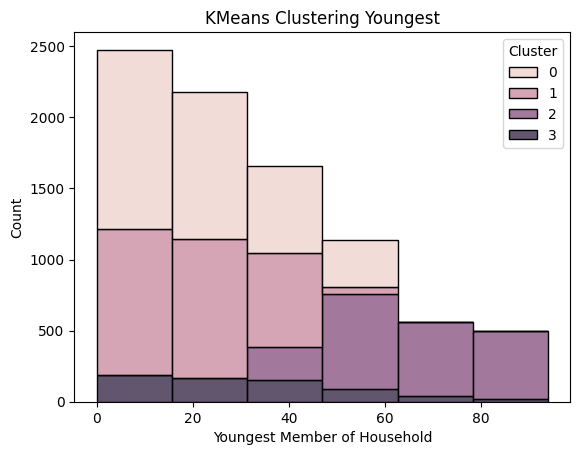

In [96]:
sns.histplot(data=regional_fam_k4, x="youngest", hue="Cluster", multiple='stack',bins=6)
plt.title('KMeans Clustering Youngest')
plt.xlabel('Youngest Member of Household')
plt.show()

Looking at this stacked histogram, it is clear than cluster 1 contains the majority of older folk and clusters 2 and 3 contain the younger folk. 

<Axes: xlabel='Cluster', ylabel='leisure_perc'>

Text(0.5, 1.0, 'KMeans Clustering')

Text(0, 0.5, '% Leisure Expenditure')

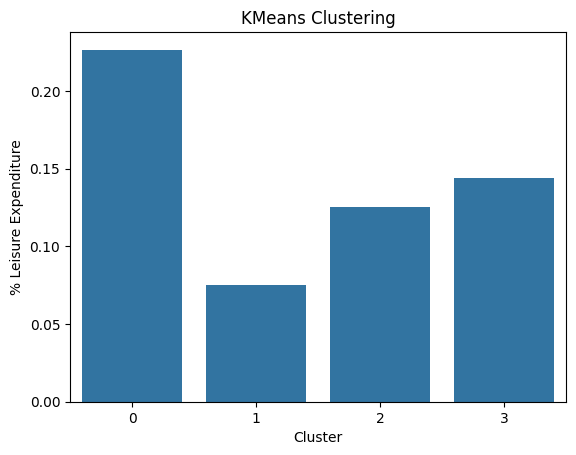

In [97]:
sns.barplot(x='Cluster', y='leisure_perc', data=regional_fam_k4, ci=None) 
plt.title('KMeans Clustering')
plt.ylabel('% Leisure Expenditure')
plt.show()

The bar plot displays percentage of income spent on leisure activities. There is a clear spike of park attendance in cluster 2, meaning they on average spend more on leisure than the other clusters.

Text(0.5, 1.0, 'Density Plot KMeans Clustering')

Text(0.5, 9.444444444444438, 'Distance from Park')

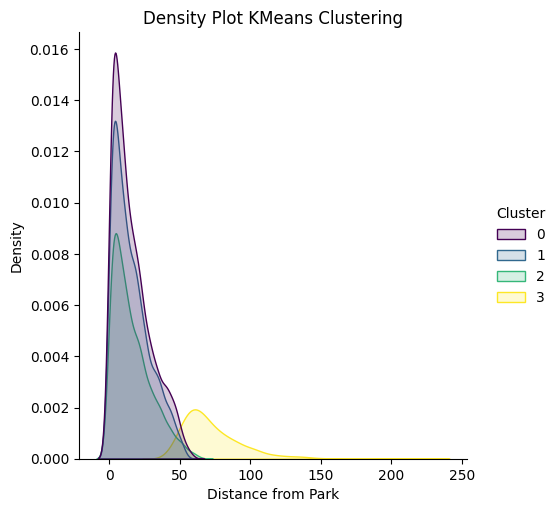

In [98]:
sns.displot(regional_fam_k4, x="dist_park", hue="Cluster", kind='kde', fill=True, palette='viridis', alpha=0.2)
plt.title('Density Plot KMeans Clustering')
plt.xlabel('Distance from Park')
plt.show()

There is a clear shift in the distance to the park. The only cluster that seems to stray a little on the higher end is cluster 3, meaning they live quite far from the park compared to the other three clusters.

Text(0.5, 1.0, 'KMeans Clustering Previous Attendance Distribution')

Text(22.569444444444443, 0.5, 'Previous Attendance')

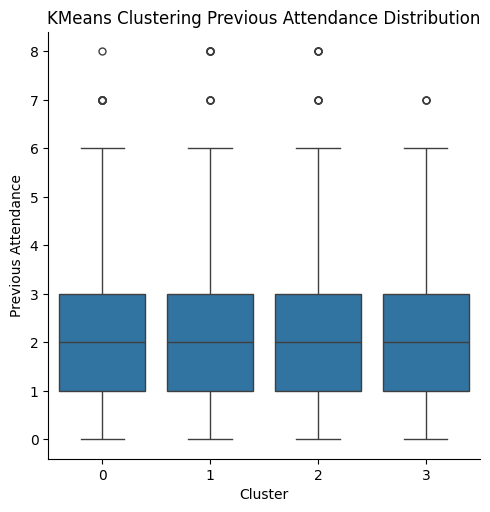

In [99]:
sns.catplot(x="Cluster", y="previous_attend", kind="box", data=regional_fam_k4)
plt.title('KMeans Clustering Previous Attendance Distribution')
plt.ylabel('Previous Attendance')
plt.show()

The cat and whisker plot is useful for getting a sense of the distribution of the clusters. While it doesn't seem interesting, because all clusters seem to have previously visited the park, on average, the same number of times, this can be useful for showing that interest in the park is about the same across all clusters.

Considering the statistics for each cluster, it would be best to prioritize clusters 0 (Youngsters) and 2 (Spenders). While the Youngster cluster doesn't spend a lot, it can be assumed that they will provide the best exposure. They have the second highest count (2706) and young people use social media quite often. This could benefit the park in the longrun. 

Cluster 2 not only has the highest count, 3252, but they also spend the most on average. This could be a good source of revenue for the park. Since both clusters live fairly close to the park, we should consider increasing local marketing over television advertising. That way, the park can reduce their costs. This can be done through posters at local restaurants, shopping malls, grocery stores, etc.

# Conjoint Analysis & Memo Section

In [100]:
bbq = pd.read_csv("bbq_lake.csv")
del bbq['bundleID']
column_names = ['Starter', "MainDish", "SaladSoup", "Side", "Desssert", "Ratings"]
bbq.columns = column_names

In [101]:
bbq_dummies = pd.get_dummies(bbq, drop_first = True) 
bbq_dummies.head()

,Ratings,Starter_Fried Chicken Tenders,Starter_Jumbo Shrimp Cocktail,Starter_Sticky Chicken Tenders,MainDish_Grilled Portobello Mushrooms,MainDish_Grilled Salmon,MainDish_Grilled Sausages,MainDish_Smoked Turkey Legs,SaladSoup_Chili,SaladSoup_Potato Salad,SaladSoup_Winter Salad,Side_Mac and Cheese,Side_Mashed Potato,Desssert_Smores
0,7.307,True,False,False,False,False,True,False,False,False,True,True,False,True
1,5.397,True,False,False,False,False,True,False,False,False,True,True,False,False
2,6.357,True,False,False,False,False,True,False,False,False,True,False,True,True
3,7.307,True,False,False,False,False,True,False,False,False,True,False,False,True
4,8.167,True,False,False,False,False,True,False,False,True,False,True,False,True


In [102]:
X = bbq_dummies[list(bbq_dummies)[1:]]
y = bbq_dummies['Ratings']

model = LinearRegression()
model.fit(X, y)
model_coeff_df = pd.DataFrame({"Food":list(bbq_dummies)[1:], "Coeff":model.coef_})

LinearRegression()

In [103]:
model_coeff_df['Category'] = model_coeff_df['Food'].str.split('_', expand=True)[0]
model_coeff_df = model_coeff_df.groupby("Category").apply(lambda x: x.sort_values('Coeff', ascending=False))
model_coeff_df

Food     Coeff   Category
Category                                                                
Desssert  12                        Desssert_Smores  1.124756   Desssert
MainDish  5               MainDish_Grilled Sausages  1.721047   MainDish
          6             MainDish_Smoked Turkey Legs -0.365250   MainDish
          4                 MainDish_Grilled Salmon -0.489291   MainDish
          3   MainDish_Grilled Portobello Mushrooms -1.663102   MainDish
SaladSoup 7                         SaladSoup_Chili  1.680605  SaladSoup
          8                  SaladSoup_Potato Salad -0.074659  SaladSoup
          9                  SaladSoup_Winter Salad -0.942001  SaladSoup
Side      10                    Side_Mac and Cheese  0.091262       Side
          11                     Side_Mashed Potato -0.868634       Side
Starter   2          Starter_Sticky Chicken Tenders  2.138604    Starter
          0           Starter_Fried Chicken Tenders  0.138903    Starter
          1           Starter_Jumbo Shrimp Cocktail -0.076465    Starter

In [104]:
vsc = pd.read_csv("vendor-costs.csv")
selected_items = ["Sticky Chicken Tenders", "Grilled Sausages","Smoked Turkey Legs", "Chili","Mac and Cheese", "Smores"]
vsc_menu = vsc[vsc.Item.isin(selected_items)].reset_index(drop = True)
vsc_menu

,Item,Item Category,Cost Per Serving (Dollars)
0,Sticky Chicken Tenders,Starters,3.40
1,Grilled Sausages,Main Dish I,5.60
2,Smoked Turkey Legs,Main Dish I,4.35
3,Chili,Salad/Soup,6.00
4,Mac and Cheese,Side,0.74
5,Smores,Dessert,1.25


## Suggestions to Lobster Land

After conducting a comprehensive linear regression analysis of customer ratings, the following food items are recommended for the Barbeque Tent at Winter Wonderland:

**Starter: Sticky Chicken Tenders ($3.40)**

The Starter selection is guided by the highest positive coefficient (2.138), indicating strong customer preference for Sticky Chicken Tenders.

**Main Dishes: Grilled Sausages & Smoked Turkey Legs ($5.60 & $4.35)**

Grilled Sausages have the highest positive coefficient (1.721) among Main Dishes, suggesting a strong likability factor. Although Smoked Turkey Legs have a negative coefficient (-0.356), it picking the best amongst the worse then compared to the other items available

**Salad Soup: Chili ($6.00)**

Chili is the second-highest in customer preference that had the only positive coefficient (1.680) meaning that it was the most preferred salad soup based on taste and preference. If the beef is substituted for bean, it can be offered to a larger group of people.

**Side: Mac & Cheese ($0.74)**

While Mac and Cheese has the only positive coefficient, in the Side category therefore it is the obvious choice to be served the the visitors at lobsterland.Paired with the Chili this combination offers a balance of meat and vegetarian options, catering to a broader audience.

**Dessert: S’mores ($1.25)**

S’mores top the Dessert category with a coefficient of 1.124, signaling a high preference among customers. This traditional dessert is likely to be a crowd-pleaser.

**Pricing Strategy:**

A flat fee of $15 for access to the Barbeque Tent is recommended to simplify the purchasing process and provide customers with clear value. The selected dishes are anticipated to be well-received based on the data-driven analysis of taste preferences, which were evaluated independently of cost considerations.

**Conclusion:**

The combination of Sticky Chicken Tenders, Grilled Sausages, Smoked Turkey Legs, Chili, Mac & Cheese, and S'mores balances customer taste preferences with cost considerations effectively. This menu aligns with customer preferences and stays within the $17 price point for a 4 course meal.

It is important to note that the overall cost of the selections should not exceed a price point when considering the quantities of each that a typical customer would consume. Further analysis may be required to ensure that the selected menu items, when offered in reasonable portion sizes, will not surpass the revenue generated by the flat entry fee.


# Forecasting Total Revenue

In [105]:
# this is data for the past 5 years of Disney's stock
disney = pd.read_csv('DIS.csv', index_col='Date', parse_dates=True)

In [106]:
disney.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-06,112.059998,114.339996,111.160004,114.330002,112.080246,10546200
2018-12-07,113.860001,113.989998,111.610001,111.980003,110.627998,8305500
2018-12-10,111.989998,112.290001,109.529999,111.860001,110.509445,7337500
2018-12-11,112.970001,113.720001,111.430000,111.970001,110.618118,6861800
2018-12-12,113.000000,113.980003,112.150002,112.209999,110.855217,7723900


In [107]:
# calculate revenue vased on close price and volume
disney['Revenue'] = disney.Close * disney.Volume

<Axes: xlabel='Date'>

Text(0.5, 1.0, 'Disney 5 Year Revenue')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Revenue')

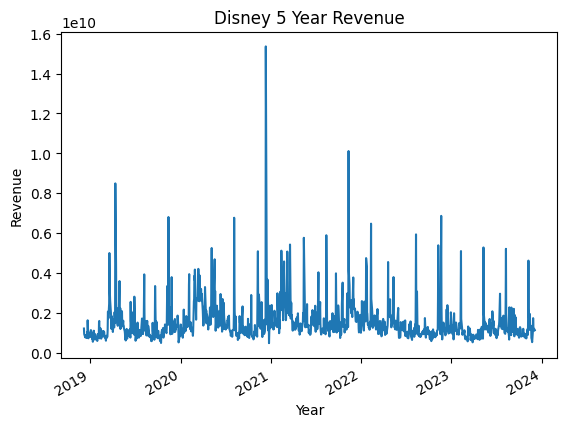

In [108]:
disney.Revenue.plot()
plt.title('Disney 5 Year Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

In [109]:
# calculate weekly mean of Revenue
weekly_mean = disney.Revenue.resample('W').mean()

## ARIMA

In [110]:
# calculate the optimal parameters for ARIMA(p, d, q)
p_l = []
q_l = []
aic_l = []
for p in range(5):
  for q in range(5):
    model = SARIMAX(weekly_mean, order=(p, 0, q), trend='c')
    results = model.fit()
    p_l.append(p)
    q_l.append(q)
    aic_l.append(results.aic)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17375D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   0.000D+00   2.174D+01
  F =   21.737511424921127     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     16      1     0     0   1.261D-05   2.165D+01
  F =   21.648067886953388     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16362D+01    |proj g|=  7.05347D-02

At iterate    5    f=  2.16342D+01    |proj g|=  4.31655D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16328D+01    |proj g|=  1.26349D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      5      1     0     0   9.036D-05   2.163D+01
  F =   21.632795311154723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.16204D+01    |proj g|=  4.93483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      7      9      1     0     0   3.656D-05   2.162D+01
  F =   21.620351357559258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16217D+01    |proj g|=  1.42828D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/Users/jiunlee/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jiunlee/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.16205D+01    |proj g|=  1.30256D-02

At iterate   10    f=  2.16205D+01    |proj g|=  8.54801D-03

At iterate   15    f=  2.16195D+01    |proj g|=  4.81828D-02

At iterate   20    f=  2.16187D+01    |proj g|=  8.05294D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     28      1     0     0   1.307D-05   2.162D+01
  F =   21.618646011492178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  2.16205D+01    |proj g|=  1.23106D-02

At iterate   15    f=  2.16204D+01    |proj g|=  6.72998D-03

At iterate   20    f=  2.16185D+01    |proj g|=  8.85850D-02

At iterate   25    f=  2.16135D+01    |proj g|=  2.88705D-02

At iterate   30    f=  2.16104D+01    |proj g|=  4.56318D-02

At iterate   35    f=  2.16098D+01    |proj g|=  3.76799D-02

At iterate   40    f=  2.16097D+01    |proj g|=  1.89774D-03

At iterate   45    f=  2.16097D+01    |proj g|=  3.94687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     61      1     0     0   4.473D-04   2.161D+01
  F =   21.6096755872

 This problem is unconstrained.



At iterate   25    f=  2.16196D+01    |proj g|=  8.69396D-03

At iterate   30    f=  2.16194D+01    |proj g|=  6.28401D-03

At iterate   35    f=  2.16180D+01    |proj g|=  6.49144D-02

At iterate   40    f=  2.16120D+01    |proj g|=  5.21623D-02

At iterate   45    f=  2.16081D+01    |proj g|=  3.12834D-02

At iterate   50    f=  2.16071D+01    |proj g|=  6.83510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     64      1     0     0   6.835D-03   2.161D+01
  F =   21.607125119799676     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/jiunlee/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/jiunlee/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jiunlee/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16208D+01    |proj g|=  1.68068D-02

At iterate    5    f=  2.16207D+01    |proj g|=  4.97753D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5      8      1     0     0   4.978D-05   2.162D+01
  F =   21.620697645584325     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  2.16215D+01    |proj g|=  1.53522D-02

At iterate   10    f=  2.16211D+01    |proj g|=  9.61373D-04

At iterate   15    f=  2.16208D+01    |proj g|=  2.19955D-02

At iterate   20    f=  2.16202D+01    |proj g|=  1.82702D-02

At iterate   25    f=  2.16190D+01    |proj g|=  1.84419D-02

At iterate   30    f=  2.16160D+01    |proj g|=  2.06783D-02

At iterate   35    f=  2.16157D+01    |proj g|=  4.19321D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     49      1     0     0   6.262D-06   2.162D+01
  F =   21.615655039776918     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   30    f=  2.16195D+01    |proj g|=  1.22704D-02

At iterate   35    f=  2.16188D+01    |proj g|=  5.93823D-02

At iterate   40    f=  2.16111D+01    |proj g|=  5.51640D-02

At iterate   45    f=  2.16084D+01    |proj g|=  1.65064D-02

At iterate   50    f=  2.16079D+01    |proj g|=  5.41629D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     70      1     0     0   5.416D-03   2.161D+01
  F =   21.607911216992942     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

/Users/jiunlee/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  2.16239D+01    |proj g|=  1.31542D-02

At iterate   10    f=  2.16204D+01    |proj g|=  1.58500D-02

At iterate   15    f=  2.16201D+01    |proj g|=  1.10741D-03

At iterate   20    f=  2.16199D+01    |proj g|=  1.37213D-02

At iterate   25    f=  2.16170D+01    |proj g|=  5.21462D-02

At iterate   30    f=  2.16127D+01    |proj g|=  3.97163D-02

At iterate   35    f=  2.16098D+01    |proj g|=  1.25685D-02

At iterate   40    f=  2.16088D+01    |proj g|=  3.39255D-02

At iterate   45    f=  2.16086D+01    |proj g|=  3.08029D-03

At iterate   50    f=  2.16086D+01    |proj g|=  3.52398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/jiunlee/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [111]:
# sort the parameters by aic value
results_df = pd.DataFrame({"p":p_l, "q":q_l, "aic":aic_l})
results_df.sort_values("aic")

,p,q,aic
18,3,3,11339.470008
15,3,0,11339.750359
19,3,4,11340.133563
12,2,2,11340.187287
23,4,3,11340.545478
20,4,0,11341.245566
16,3,1,11341.729649
8,1,3,11342.079091
17,3,2,11342.170510
22,4,2,11342.603241


In [112]:
# based on the output above, we select ARIMA(3, 0, 3)
sarimax = SARIMAX(weekly_mean, order=(3, 0, 3), trend='c')
results = sarimax.fit() # run the fit
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16222D+01    |proj g|=  4.53750D-02

At iterate    5    f=  2.16216D+01    |proj g|=  4.70252D-03


 This problem is unconstrained.



At iterate   10    f=  2.16205D+01    |proj g|=  1.23106D-02

At iterate   15    f=  2.16204D+01    |proj g|=  6.72998D-03

At iterate   20    f=  2.16185D+01    |proj g|=  8.85850D-02

At iterate   25    f=  2.16135D+01    |proj g|=  2.88705D-02

At iterate   30    f=  2.16104D+01    |proj g|=  4.56318D-02

At iterate   35    f=  2.16098D+01    |proj g|=  3.76799D-02

At iterate   40    f=  2.16097D+01    |proj g|=  1.89774D-03

At iterate   45    f=  2.16097D+01    |proj g|=  3.94687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     61      1     0     0   4.473D-04   2.161D+01
  F =   21.6096755872

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  262
Model:               SARIMAX(3, 0, 3)   Log Likelihood               -5661.735
Date:                Tue, 12 Dec 2023   AIC                          11339.470
Time:                        19:16:49   BIC                          11368.017
Sample:                    12-09-2018   HQIC                         11350.944
                         - 12-10-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.467e+08   5.56e-11   1.16e+19      0.000    6.47e+08    6.47e+08
ar.L1          0.1098      0.044      2.468      0.014       0.023       0.197
ar.L2         -0.3562      0.042     -8.500      0.000      -0.438      -0.274
ar.L3          0.8099      0.041     19.968      0.000       0.730       0.889
ma.L1          0.2120      0.077      2.737      0.006       0.060       0.364
ma.L2          0.5368      0.071      7.564      0.000       0.398       0.676
ma.L3         -0.5016      0.083     -6.073      0.000      -0.663      -0.340
sigma2       3.64e+17   2.04e-19   1.78e+36      0.000    3.64e+17    3.64e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               293.87
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             1.83
Prob(H) (two-sided):                  0.22   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.71e+50. Standard errors may be unstable.
"""

In [113]:
# obtain forecasted values
forecast = results.get_prediction(start=-50)
mean_forecast = forecast.predicted_mean

In [114]:
# obtain the predicted values based on our model
times2 = pd.date_range(start = '2023-01-01', end = '2023-12-10', freq='W')
predictions = pd.Series(mean_forecast.values, index = times2)

<Figure size 1100x500 with 0 Axes>

Text(0.5, 1.0, 'Disney Forecast')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Total Revenue')

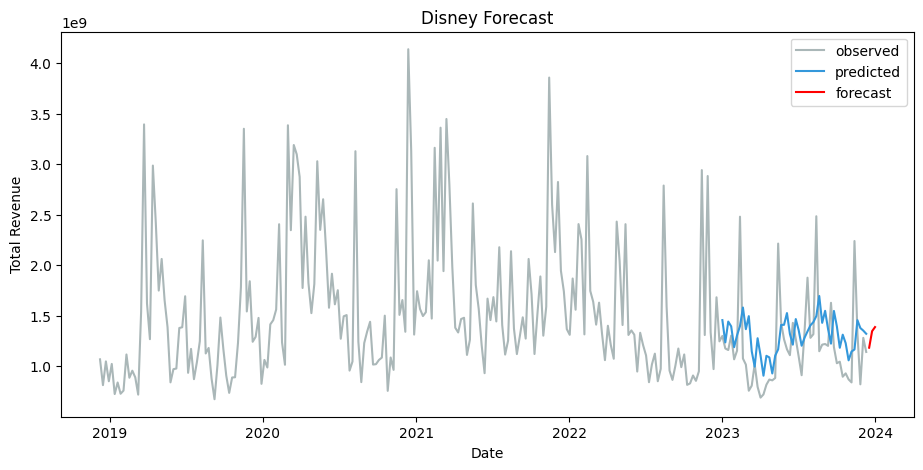

In [116]:
plt.figure(figsize=(11,5))
plt.plot(weekly_mean, label='observed', color='#aab7b8')
plt.plot(predictions, color='#3498db' , label= 'predicted')
plt.plot(results.forecast(3), color = 'red', label = 'forecast')
plt.title('Disney Forecast')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.legend()
plt.savefig('forecasting.png', dpi=300, facecolor='white')
plt.show()

In the section above, we use Disney's (DIS) past five years worth of reported stock shares to forecast end of the year revenue for 2023. We first used Holt's method but found the model performance to be mediocre, unable to capture the large fluctuations in Disney's stock data. We therefore moved onto an ARIMA model. We select to forecast weekly means to subdue any noise caused by the market. 

As you can see from the figure above, our predictive model which we use as the basis for our forecast (the blue line) is still quite off. However, if you shift it down towards the observed data (the grey line), you can see that the trend follows pretty closely to the observed values. This indicates that our predictive model is overpredicting the revenue. Overall, this demonstrates the difficulty of forecasting with time series data. The small red line represents the last three weeks of this year and records our forecasted values. 

# Classification

In [117]:
carnival_visitors = pd.read_csv("carnival-visitors.csv")

In [118]:
carnival_visitors.head()

,visitorID,age,gender,prev_wincarn,homestate,phys_level,travel_dist,occupation,companion_type,ski_snowboard,social_media,preference
0,1391,23,Male,2,Quebec,Sedentary,13.752619,student,fam_children,1,0.47,Indoor
1,1463,31,Male,0,Quebec,Sedentary,6.783148,blue collar,fam_children,1,0.73,Outdoor
2,1859,39,Male,1,Quebec,Sedentary,3.469193,white collar,fam_children,1,0.98,Outdoor
3,1523,24,Male,3,Quebec,Sedentary,16.867182,student,solo,1,0.30,Outdoor
4,100,45,Male,2,Quebec,Sedentary,13.083858,white collar,friends,1,0.34,Outdoor


In [119]:
for i in list(carnival_visitors):
    print(i, carnival_visitors[i].nunique())

visitorID 2400
age 68
gender 2
prev_wincarn 10
homestate 10
phys_level 3
travel_dist 2400
occupation 5
companion_type 3
ski_snowboard 2
social_media 101
preference 2


In [120]:
del carnival_visitors['visitorID']
del carnival_visitors['travel_dist']

#Delete column with all unique observations

In [121]:
carnival_visitors.preference.value_counts()
carnival_visitors.preference.value_counts(normalize = True)

preference
Outdoor    1425
Indoor      975
Name: count, dtype: int64

preference
Outdoor    0.59375
Indoor     0.40625
Name: proportion, dtype: float64

In [122]:
missing_values = carnival_visitors.isna().sum() 
print(missing_values)

age                 0
gender              0
prev_wincarn        0
homestate           0
phys_level        146
occupation         50
companion_type      0
ski_snowboard       0
social_media        0
preference          0
dtype: int64


In [123]:
carnival_visitors.phys_level.value_counts(normalize = True)

phys_level
Moderate       0.444543
Sedentary      0.342059
Very Active    0.213398
Name: proportion, dtype: float64

In [124]:
carnival_visitors.occupation.value_counts(normalize = True)

occupation
white collar    0.427234
blue collar     0.254468
student         0.143830
retired         0.122979
gig worker      0.051489
Name: proportion, dtype: float64

In [125]:
list(carnival_visitors)

['age',
 'gender',
 'prev_wincarn',
 'homestate',
 'phys_level',
 'occupation',
 'companion_type',
 'ski_snowboard',
 'social_media',
 'preference']

In [126]:
#Replace missing values with Most Freqeunt Value
carnival_visitors.phys_level = carnival_visitors.phys_level.fillna(carnival_visitors.phys_level.mode().iloc[0])
carnival_visitors.occupation = carnival_visitors.occupation.fillna(carnival_visitors.occupation.mode().iloc[0])

In [127]:
carnival_visitors['preference_indoor'] = np.where(carnival_visitors['preference'] == "Indoor", 1, 0)
del carnival_visitors['preference']

In [128]:
carnival_visitors_dummies = pd.get_dummies(carnival_visitors)
carnival_visitors_dummies

,age,prev_wincarn,ski_snowboard,social_media,preference_indoor,gender_Female,gender_Male,homestate_Connecticut,homestate_Maine,homestate_Massachusetts,...,phys_level_Sedentary,phys_level_Very Active,occupation_blue collar,occupation_gig worker,occupation_retired,occupation_student,occupation_white collar,companion_type_fam_children,companion_type_friends,companion_type_solo
0,23,2,1,0.47,1,False,True,False,False,False,...,True,False,False,False,False,True,False,True,False,False
1,31,0,1,0.73,0,False,True,False,False,False,...,True,False,True,False,False,False,False,True,False,False
2,39,1,1,0.98,0,False,True,False,False,False,...,True,False,False,False,False,False,True,True,False,False
3,24,3,1,0.30,0,False,True,False,False,False,...,True,False,False,False,False,True,False,False,False,True
4,45,2,1,0.34,0,False,True,False,False,False,...,True,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,46,1,0,0.49,0,True,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
2396,72,0,0,0.75,1,True,False,False,True,False,...,False,False,True,False,False,False,False,False,True,False
2397,26,3,0,0.06,1,True,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
2398,38,2,0,0.16,1,True,False,False,True,False,...,False,True,False,True,False,False,False,False,True,False


In [129]:
X = carnival_visitors_dummies.drop('preference_indoor', axis = 1) 
y = carnival_visitors_dummies['preference_indoor']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 348)

In [131]:
rf = RandomForestClassifier(random_state = 812) 
param_grid = {
'n_estimators': [10, 15, 20], 
'max_depth': [8, 10, 15],
'min_samples_split': [2, 5, 8], 
'min_samples_leaf': [2, 4, 8]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1) 
grid_search.fit(X_train, y_train)
print(f'Best hyperparameters: {grid_search.best_params_}')

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=812),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10, 15],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [10, 15, 20]})

Best hyperparameters: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 15}


In [132]:
rf_best = RandomForestClassifier(**grid_search.best_params_) 
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=4, n_estimators=15)

In [133]:
feature_importance = rf_best.feature_importances_
sorted_idx = feature_importance.argsort()

df_importance = pd.DataFrame({'Variable': list(X_train), "Score": feature_importance}) 
df_importance.sort_values("Score", ascending = False).reset_index(drop = True)

,Variable,Score
0,phys_level_Sedentary,0.191158
1,social_media,0.130158
2,age,0.124252
3,phys_level_Moderate,0.093855
4,phys_level_Very Active,0.060728
5,prev_wincarn,0.049700
6,homestate_Quebec,0.039752
7,gender_Male,0.027094
8,companion_type_solo,0.026677
9,occupation_white collar,0.025369


<BarContainer object of 27 artists>

([<matplotlib.axis.YTick at 0x177531dd0>,
 [Text(0, 0, 'homestate_Vermont'),
  Text(0, 1, 'homestate_Connecticut'),
  Text(0, 2, 'homestate_Ontario'),
  Text(0, 3, 'homestate_New Jersey'),
  Text(0, 4, 'occupation_student'),
  Text(0, 5, 'homestate_Rhode Island'),
  Text(0, 6, 'occupation_retired'),
  Text(0, 7, 'occupation_gig worker'),
  Text(0, 8, 'occupation_blue collar'),
  Text(0, 9, 'homestate_Maine'),
  Text(0, 10, 'homestate_New York'),
  Text(0, 11, 'ski_snowboard'),
  Text(0, 12, 'companion_type_friends'),
  Text(0, 13, 'homestate_New Hampshire'),
  Text(0, 14, 'homestate_Massachusetts'),
  Text(0, 15, 'companion_type_fam_children'),
  Text(0, 16, 'gender_Female'),
  Text(0, 17, 'occupation_white collar'),
  Text(0, 18, 'companion_type_solo'),
  Text(0, 19, 'gender_Male'),
  Text(0, 20, 'homestate_Quebec'),
  Text(0, 21, 'prev_wincarn'),
  Text(0, 22, 'phys_level_Very Active'),
  Text(0, 23, 'phys_level_Moderate'),
  Text(0, 24, 'age'),
  Text(0, 25, 'social_media'),
  Text(

Text(0.5, 0, 'Feature Importance')

Text(0, 0.5, 'Features')

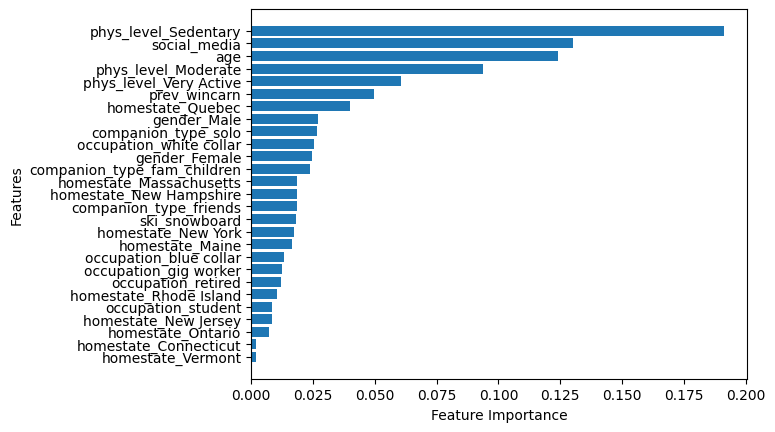

In [134]:
plt.barh(range(X.shape[1]), feature_importance[sorted_idx], align="center")
plt.yticks(range(X.shape[1]), rf_best.feature_names_in_[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted')

Text(70.72222222222221, 0.5, 'True')

Text(0.5, 1.0, 'Confusion Matrix with Row and Column Totals')

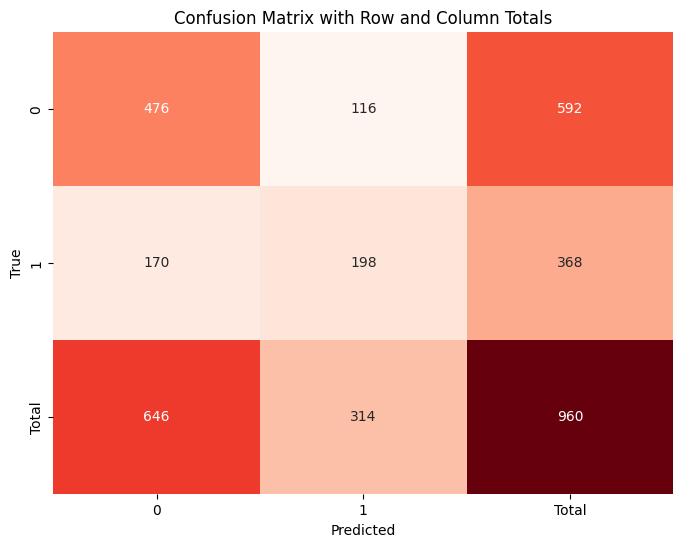

a. Accuracy: 70.208
b. Sensitivity: 53.804
c. Specificity: 80.405
d. Precision: 63.057
e. Balanced Accuracy: 67.105


In [135]:
y_pred = rf_best.predict(X_test) 
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
# Compute row and column sums 
row_sums = np.sum(cm, axis=1) 
col_sums = np.sum(cm, axis=0)
# Add row and column sums to the confusion matrix 
cm_with_totals = np.vstack((cm, col_sums))
cm_with_totals = np.column_stack((cm_with_totals, np.append(row_sums, np. sum(col_sums))))

# Plot the confusion matrix with totals 
plt.figure(figsize=(8, 6))
sns.heatmap(cm_with_totals, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=["0", "1", "Total"], yticklabels=["0", "1", "Total"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Row and Column Totals')
plt.show()

# a. Accuracy
accuracy = accuracy_score(y_test, y_pred) 
print("a. Accuracy:", round(accuracy * 100,3))
# b. Sensitivity (Recall)
sensitivity = recall_score(y_test, y_pred)
print("b. Sensitivity:", round(sensitivity * 100,3)) 
# c. Specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
specificity = tn / (tn + fp)
print("c. Specificity:", round(specificity * 100,3)) 
# d. Precision
precision = precision_score(y_test, y_pred) 
print("d. Precision:", round(precision * 100,3))
# e. Balanced Accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred) 
print("e. Balanced Accuracy:", round(balanced_accuracy * 100,3))

These features suggest that people who are more physically active, who have attended winter carnivals in the past, and who live in colder states are more likely to be interested in outdoor activities. People who identify as female or who are attending with family or children are more likely to be interested in indoor activities.

Lobster Land management can use these insights to develop more targeted marketing campaigns. For example, they could target people who are physically active with ads for outdoor activities such as ice skating or snowmobile races. They could target families with young children with ads for indoor activities such as craft fairs or holiday shows. They could also promote their indoor activities to people who live in colder states, where outdoor activities may be less appealing in the winter.


Marketing approaches that Lobster Land can apply based on the outcomes

**Here are some specific marketing approaches that Lobster Land can apply based on the random forest model results:**

Target people who are physically active with ads for outdoor activities. Lobster Land could run ads on social media platforms such as Facebook and Instagram that target people who have indicated that they are interested in fitness or outdoor activities. These ads could highlight the park's outdoor attractions, such as its ice skating rink, snowmobile trails, and tubing hill.

Target families with young children with ads for indoor activities. Lobster Land could run ads on TV and radio stations that are popular with families. These ads could highlight the park's indoor attractions, such as its craft fairs, holiday shows, and arcade.

Promote indoor activities to people who live in colder states. Lobster Land could run ads in regional magazines and newspapers that are popular in colder states. These ads could highlight the park's indoor attractions, such as its heated tents and indoor ice skating rink.

The model can then also be used to predict next year’s visitor preference and therefore finances can be strategically allocated to those departments and activities.


# A/B Testing

In [136]:
ice_sculp = pd.read_csv("ice_sculptures.csv")

In [137]:
ice_sculp.drop('recipient', axis=1,inplace=True)

In [138]:
ice_sculp.groupby('pic_seen')['register'].value_counts(normalize = True)

pic_seen         register
Captain America  0           0.651489
                 1           0.348511
Ironman          0           0.559459
                 1           0.440541
Spiderman        0           0.658537
                 1           0.341463
Name: proportion, dtype: float64

In [139]:
Sculpture_Proportion = ice_sculp.register.sum()/ice_sculp.shape[0]

Expected_I = round(ice_sculp[ice_sculp.pic_seen == "Ironman"].shape[0] * Sculpture_Proportion, 4)
Expected_S = round(ice_sculp[ice_sculp.pic_seen == "Spiderman"].shape[0] * Sculpture_Proportion, 4)
Expected_C = round(ice_sculp[ice_sculp.pic_seen == "Captain America"].shape[0] * Sculpture_Proportion, 4)

print(Expected_I)
print(Expected_S)
print(Expected_C)

417.5559
431.8506
429.5935


In [140]:
ice_sculp[ice_sculp.register == 1].pic_seen.value_counts()

pic_seen
Ironman            489
Captain America    398
Spiderman          392
Name: count, dtype: int64

In [141]:
# Define the observed frequencies of returns for each day_code group 
observed_frequencies = [489, 398, 392]  # Replace with actual numbers
# Define the expected frequencies assuming no difference (equal distribution) 
expected_frequencies = [Expected_I, Expected_C, Expected_S]
# Perform the chi-square goodness of fit test
chi_square_statistic, p_value = stats.chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)
# Print the results
print("Chi-square statistic:", round(chi_square_statistic, 3)) 
print("p-value:", p_value)

Chi-square statistic: 18.225
p-value: 0.00011028040381769651


In [142]:
ice_sculp.groupby("pic_seen")['register'].value_counts(normalize = True)

pic_seen         register
Captain America  0           0.651489
                 1           0.348511
Ironman          0           0.559459
                 1           0.440541
Spiderman        0           0.658537
                 1           0.341463
Name: proportion, dtype: float64

In [143]:
# DANYA'S ATTEMPT
# running the t-test on site_duration
# Perform t-tests for each pair of 'pic_seen'
pic_seen_categories = ice_sculp['pic_seen'].unique()

for i in range(len(pic_seen_categories)):
    for j in range(i + 1, len(pic_seen_categories)):
        category1 = pic_seen_categories[i]
        category2 = pic_seen_categories[j]
        
        # Subset the data for each category
        data_category1 = ice_sculp[ice_sculp['pic_seen'] == category1]['site_duration']
        data_category2 = ice_sculp[ice_sculp['pic_seen'] == category2]['site_duration']
        
        # Perform t-test
        t_stat, p_value = ttest_ind(data_category1, data_category2, equal_var = False)
        
        # Display results
        print(f"T-test between {category1} and {category2}:")
        print(f"T-statistic: {t_stat}")
        print(f"P-value: {p_value}")
        print("")

        # Interpret the results based on the p-value
        if p_value < 0.05:
            print("There is a significant difference in site duration between the two categories.")
        else:
            print("There is no significant difference in site duration between the two categories.")
        print("\n" + "="*50 + "\n")

T-test between Ironman and Spiderman:
T-statistic: -10.001841948108055
P-value: 5.917256397701659e-23

There is a significant difference in site duration between the two categories.


T-test between Ironman and Captain America:
T-statistic: 178.43526393191596
P-value: 0.0

There is a significant difference in site duration between the two categories.


T-test between Spiderman and Captain America:
T-statistic: 112.41074656435279
P-value: 0.0

There is a significant difference in site duration between the two categories.




In [144]:
print(f"Total time spent on site, Ironman: {ice_sculp.loc[ice_sculp['pic_seen'] == 'Ironman', 'site_duration'].mean():.2f}")
print(f"Total time spent on site, Captain America: {ice_sculp.loc[ice_sculp['pic_seen'] == 'Captain America', 'site_duration'].mean():.2f}")
print(f"Total time spent on site, Spiderman: {ice_sculp.loc[ice_sculp['pic_seen'] == 'Spiderman', 'site_duration'].mean():.2f}")

Total time spent on site, Ironman: 22.95
Total time spent on site, Captain America: 10.98
Total time spent on site, Spiderman: 24.29


In [145]:
# DANYA'S ATTEMPT
# PIC_SEEN AND SPEND
for i in range(len(pic_seen_categories)):
    for j in range(i + 1, len(pic_seen_categories)):
        category1 = pic_seen_categories[i]
        category2 = pic_seen_categories[j]
        
        # Subset the data for each category
        data_category1 = ice_sculp[ice_sculp['pic_seen'] == category1]['spend']
        data_category2 = ice_sculp[ice_sculp['pic_seen'] == category2]['spend']
        
        # Perform t-test
        t_stat, p_value = ttest_ind(data_category1, data_category2, equal_var=False)
        
        # Display results
        print(f"T-test between {category1} and {category2} on spend:")
        print(f"T-statistic: {t_stat}")
        print(f"P-value: {p_value}")
        print("")

        # Interpret the results based on the p-value
        if p_value < 0.05:
            print("There is a significant difference in spend between the two categories.")
        else:
            print("There is no significant difference in spend between the two categories.")
        print("\n" + "="*50 + "\n")

T-test between Ironman and Spiderman on spend:
T-statistic: 41.02687256136666
P-value: 1.7008147207546044e-248

There is a significant difference in spend between the two categories.


T-test between Ironman and Captain America on spend:
T-statistic: -23.859305670179324
P-value: 3.887318300569778e-106

There is a significant difference in spend between the two categories.


T-test between Spiderman and Captain America on spend:
T-statistic: -48.18418360763735
P-value: 0.0

There is a significant difference in spend between the two categories.




In [146]:
print(f"Total merchandise spending, Ironman: {ice_sculp.loc[ice_sculp['pic_seen'] == 'Ironman', 'spend'].mean():.2f}$")
print(f"Total merchandise spending, Captain America: {ice_sculp.loc[ice_sculp['pic_seen'] == 'Captain America', 'spend'].mean():.2f}$")
print(f"Total merchandise spending, Spiderman: {ice_sculp.loc[ice_sculp['pic_seen'] == 'Spiderman', 'spend'].mean():.2f}$")

Total merchandise spending, Ironman: 16.78$
Total merchandise spending, Captain America: 18.61$
Total merchandise spending, Spiderman: 14.02$


### Picture to be used for registration

*Chi-Squared Test*
Test whether the picture shown in the mail has any effect on the distribution of people that registered for Lobster Lobster Lands 2023 Winter Wonderland.

*H0:* There is no difference in the pic seen and distribution of people that registered for the 2023 Winter Wonderland.

*H1:* There is a difference in the pic seen and distribution of people that registered for the 2023 Winter Wonderland.

&nbsp;&nbsp;&nbsp;&nbsp;Chi-square statistic: 18.225

&nbsp;&nbsp;&nbsp;&nbsp;p-value: 0.0001

**Conclusion:**

Since p-value is lower than the set threshold of 0.005, we reject the null and conclude that the pic seen in the mail has an effect on the distribution of people that registered for the 2023 Winter Wonderland. Ironman has the highest percentage of users registered for the 2023 Winter Wonderland, if the goal of Lobster Land is to get as many as they can to sign up, they should include the Ironman ice sculpture image in their promotional mails. 

### Picture to be used for website expenditure

**T-test**

Test to see if there is significant difference between the means of the groups.

*Groups here are the people who got either Spiderman, Ironman or Captain America in the promotional email*

*H0:* The difference in the mean amount spent (in dollars) on the Lobsterland website between and 2 groups is 0

*H1:* The difference in the mean amount spent  (in dollars) on the Lobsterland website between 2 groups not 0.

**T-test between Ironman and Spiderman:**

&nbsp;&nbsp;&nbsp;&nbsp;T-statistic: 41.03

&nbsp;&nbsp;&nbsp;&nbsp;P-value: 1.7008147207546044e-248

**T-test between Ironman and Captain America:**

&nbsp;&nbsp;&nbsp;&nbsp;T-statistic: -23.86

&nbsp;&nbsp;&nbsp;&nbsp;P-value: 3.887318300569778e-106

**T-test between Spiderman and Captain America:**

&nbsp;&nbsp;&nbsp;&nbsp;T-statistic: -48.18

&nbsp;&nbsp;&nbsp;&nbsp;P-value: 0.0

Since the p-values for all 3 tests are 0, that means there is statistically significant difference between the mean spends between the 3 groups.

**Mean Spend on website for each group:**

&nbsp;&nbsp;&nbsp;&nbsp;Total merchandise spending, Ironman: 16.78$

&nbsp;&nbsp;&nbsp;&nbsp;Total merchandise spending, Captain America: 18.61$

&nbsp;&nbsp;&nbsp;&nbsp;Total merchandise spending, Spiderman: 14.02$

In lieu of the 3 tests that were performed and mean merchandise spend given, if Lobserland wants to boost online revenue, they should use the Captain America ice sculpture image in their promotional emails.



### Picture to be used for website exposure

Test to see if there is significant difference between the means of the groups.
*Groups here are the people who got either Spiderman, Ironman or Captain America in the promotional email*


*H0:* The difference in the mean amount of time spent on the Lobsterland website between and 2 groups is 0.

*H1:* The difference in the mean amount of time spent on the Lobsterland website between and 2 groups not 0.


*T-test between Ironman and Spiderman:*

&nbsp;&nbsp;&nbsp;&nbsp;T-statistic: -10.00

&nbsp;&nbsp;&nbsp;&nbsp;P-value: 5.917256397701659e-23

*T-test between Ironman and Captain America:*

&nbsp;&nbsp;&nbsp;&nbsp;T-statistic: 178.43

&nbsp;&nbsp;&nbsp;&nbsp;P-value: 0.0

*T-test between Spiderman and Captain America:*

&nbsp;&nbsp;&nbsp;&nbsp;T-statistic: 112.41

&nbsp;&nbsp;&nbsp;&nbsp;P-value: 0.0

Since the p-values for all 3 tests are 0, that means there is statistically significant difference between the mean amount of time spent between the 3 groups.

**Mean Spend on website for each group:**

&nbsp;&nbsp;&nbsp;&nbsp;Total time spent on site, Ironman: 22.95

&nbsp;&nbsp;&nbsp;&nbsp;Total time spent on site, Captain America: 10.98

&nbsp;&nbsp;&nbsp;&nbsp;Total time spent on site, Spiderman: 24.29

In lieu of the 3 tests that were performed and mean time spent  given, if Lobserland wants users to remain on the website, they should use the Spiderman ice sculpture image in their promotional emails.


**In conclusion, all 3 images will provide some kind of benefit to Lobster Land, either in terms of engagement or direct revenue.**

In [147]:
import matplotlib.pyplot as plt

# Create a list of x- and y-values
ironman_data = ice_sculp[(ice_sculp.pic_seen == 'Ironman') & (ice_sculp.register == 1)]
spiderman_data = ice_sculp[(ice_sculp.pic_seen == 'Spiderman') & (ice_sculp.register == 1)]
Captain_America_data = ice_sculp[(ice_sculp.pic_seen == 'Captain America') & (ice_sculp.register == 1)]


<Axes: xlabel='spend', ylabel='Count'>

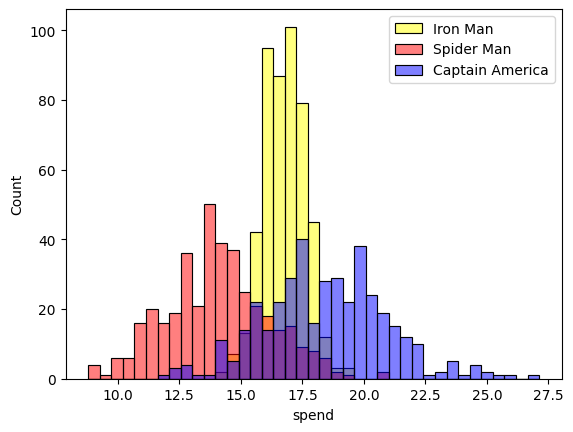

In [148]:
ice_sculp_1 = ice_sculp[ice_sculp.register == 1]
custom_palette = {'Captain America': 'blue', 'Spiderman': 'red', 'Ironman': 'yellow'}
sns.histplot(data = ice_sculp_1, x="spend", hue="pic_seen", stat="count", edgecolor='black', palette=custom_palette)
plt.grid(False)
plt.legend(["Iron Man", "Spider Man", "Captain America"])

filepath = "histogram.png"
plt.savefig(filepath, dpi=300, facecolor='white')

plt.show( )

# Conclusion

In the end, the question we want to answer is this: "How can Lobster Land better its services to gain exposure and customer satisfcation?" We answer this question using a multitude of quantative statistical analyses. Here are the main insights we'd like to provide Lobster Land.

The first being that Lobster Land needs to know their customer base. We begin by providing an overall exploratory data analysis with Tableau and summary statistics; this allows us to gain a general perspective. Following this, the k-means clustering method allows us to essentially segment possible households into groups for targeted marketing strategies. By offering a glimpse into cluster characteristics, we can make assumptions about possible marketing tactics and generature exposure, which leads to revenue. 

Additionally, our analysis of customer preferences and behaviors provides valuable insights for Lobsterland to enhance visitor engagement and profitability. By leveraging the results of our classification model, Lobsterland can anticipate future visitor preferences and allocate resources strategically, minimizing unnecessary expenditures and increasing revenue. Additionally, our conjoint analysis of food options highlights the top-rated items that Lobsterland can incorporate into their Winter Wonderland offerings, resulting in heightened visitor satisfaction and a more streamlined menu.

Since our collaboration is with Marvel, we must make use of the franchise's popularity. Their variety of intellectual properties can help draw in not only Lobster Land fans but also Marvel fans. Leveraging the popularity of the Ironman and Captain America ice sculptures can increase registration numbers and merchandise sales, respectively. By highlighting these captivating images in promotional emails and offering exclusive Winter Wonderland-themed merchandise, Lobsterland can attract fans and customers eager to own a piece of the unique and memorable experience. This strategic approach not only generates additional revenue but also serves as a lasting reminder of the Winter Wonderland event for attendees and fans alike.

Overall, our analysis provides Lobsterland with actionable insights to optimize their marketing strategies, enhance visitor experiences, and ultimately drive higher engagement and revenue. By leveraging these insights, Lobsterland can continue to innovate and improve, solidifying its position as a premier winter carnival destination.